# jiu-jitsu-auto-scoring
*This notebook is a **WIP**!*


In [1]:
# prompt: mount drive and clone the repository in the current branch, the organization is called jiu-jitsu-auto-scoring and the repository is called model
from google.colab import drive

BRANCH = "5-try-out-vitpose" # Write the name of the branch you're working in here

!git clone -q https://github.com/jiu-jitsu-auto-scoring/model.git
%cd /content/model
!git pull
!git checkout $BRANCH

fatal: destination path 'model' already exists and is not an empty directory.
/content/model
Already up to date.
Already on '5-try-out-vitpose'
Your branch is up to date with 'origin/5-try-out-vitpose'.


In [2]:
!git clone https://github.com/ViTAE-Transformer/ViTPose.git
%cd ViTPose

!pip install -r requirements.txt
!pip install -e .

!pip install supervision # for visualizing keypoints


fatal: destination path 'ViTPose' already exists and is not an empty directory.
/content/model/ViTPose
Ignoring dataclasses: markers 'python_version == "3.6"' don't match your environment
  Cloning https://github.com/svenkreiss/poseval.git to /tmp/pip-install-kpp0udg5/poseval_1219af33463b4e0f8994043a16f930e8
  Running command git clone --filter=blob:none --quiet https://github.com/svenkreiss/poseval.git /tmp/pip-install-kpp0udg5/poseval_1219af33463b4e0f8994043a16f930e8
  Resolved https://github.com/svenkreiss/poseval.git to commit 3128c5cbcf90946e5164ff438ad651e113e64613
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
Obtaining file:///content/model/ViTPose
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmpose
    Found existing installation: mmpose 0.24.0
    Uninstalling mmpose-0.24.0:
      Successfully uninstalled mmpose-0.24.0
  Running setup.py develop for mmpose


#0. Imports and such
Upload the required checkpoint into that folder

In [3]:
!mkdir -p checkpoints

In [4]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation
from transformers import AutoImageProcessor, DeformableDetrForObjectDetection
import torch
from PIL import Image
import requests

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Detect Humans on the image

In [6]:
url = "http://images.cocodataset.org/val2017/000000000139.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [18]:

processor = AutoImageProcessor.from_pretrained("SenseTime/deformable-detr")
model = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr")

inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.7
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.3
    )

result = results[0]

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

# Human label refers 0 index in COCO dataset
# Get the boxes around persons only from the result
person_boxes = result["boxes"][result["labels"] == 1]
# Convert to numpy array
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COC (x1, y1, w, h) format

person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

print(person_boxes)

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Detected chair with confidence 0.876 at location [291.77, 219.65, 351.19, 316.81]
Detected chair with confidence 0.875 at location [361.35, 218.32, 415.28, 318.48]
Detected tv with confidence 0.86 at location [7.02, 167.44, 155.46, 264.2]
Detected person with confidence 0.798 at location [423.03, 157.63, 465.18, 299.66]
Detected chair with confidence 0.776 at location [408.83, 219.98, 443.59, 307.83]
Detected bottle with confidence 0.693 at location [549.26, 297.38, 587.99, 403.37]
Detected vase with confidence 0.644 at location [350.87, 205.61, 362.78, 231.2]
Detected vase with confidence 0.634 at location [166.56, 233.22, 186.53, 268.21]
Detected vase with confidence 0.613 at location [242.12, 198.4, 253.34, 213.0]
Detected potted plant with confidence 0.59 at location [232.29, 171.75, 265.9, 212.31]
Detected refrigerator with confidence 0.574 at location [443.15, 166.06, 513.5, 292.18]
Detected person with confidence 0.454 at location [384.21, 170.95, 401.02, 211.32]
Detected vase w

# 2. Detect Keypoints for each person found

In [19]:
image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
image_model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

if len(person_boxes) > 0:
  image_inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt")
  with torch.no_grad():
      outputs = image_model(**image_inputs)

  pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
  image_pose_result = pose_results[0]  # results for first image
else:
  print("No humans found")

#3. Display Results

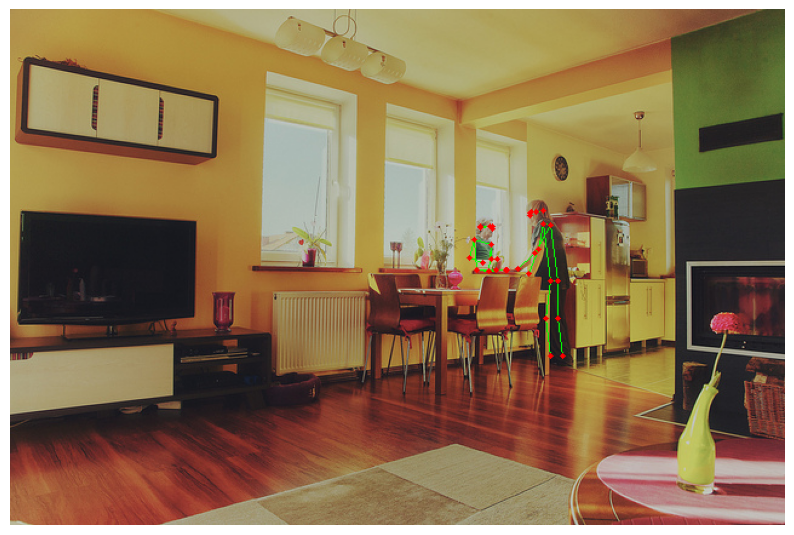

In [20]:
import supervision as sv
xy = torch.stack([pose_result['keypoints'] for pose_result in image_pose_result]).cpu().numpy()
scores = torch.stack([pose_result['scores'] for pose_result in image_pose_result]).cpu().numpy()

key_points = sv.KeyPoints(
    xy=xy, confidence=scores
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.GREEN,
    thickness=1
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.RED,
    radius=2
)
annotated_frame = edge_annotator.annotate(
    scene=image.copy(),
    key_points=key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points
)

import matplotlib.pyplot as plt

# Display the annotated image
plt.figure(figsize=(10, 10))
plt.imshow(annotated_frame)
plt.axis('off')
plt.show()
